In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper as hlp
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Fetch dataset and create in & out dataframes

In [2]:
incomes_endpoint = 'https://data.austintexas.gov/resource/wter-evkm.json'
outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

import requests
params = {'$limit': 10000000} # If not specified it only returns 1000 records
r = requests.get(incomes_endpoint, params)
in_df = pd.DataFrame(r.json())
r = requests.get(outcomes_endpoint, params)
out_df = pd.DataFrame(r.json())

in_df['income_time'] = pd.to_datetime(in_df['datetime'])
out_df['outcome_time'] = pd.to_datetime(out_df['datetime'])
out_df['date_of_birth'] = pd.to_datetime(out_df['date_of_birth'])

in_df.drop(['datetime','datetime2'], axis=1, inplace=True)
out_df.drop(['monthyear', 'datetime'], axis=1, inplace=True)

print('Incomes shape',in_df.shape)
print('Outcomes shape',out_df.shape)


Incomes shape (123102, 11)
Outcomes shape (122839, 11)


In [4]:
in_df.head(5)

,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time
0,A827898,1511 Faro Dr in Austin (TX),Public Assist,Normal,Dog,Intact Female,4 months,Border Collie/Australian Cattle Dog,White/Black,NaN,2021-01-03 09:04:00
1,A827897,1215 W Slaughter Ln in Austin (TX),Stray,Normal,Dog,Intact Female,1 month,Rottweiler,Black/Tan,NaN,2021-01-03 08:44:00
2,A784105,Loyola And 183 in Austin (TX),Stray,Injured,Dog,Neutered Male,2 years,Harrier,Liver Tick,Frankie,2021-01-03 08:28:00
3,A827892,4434 Frontier Trail in Austin (TX),Owner Surrender,Injured,Cat,Intact Male,1 year,Domestic Shorthair,Orange Tabby,NaN,2021-01-03 08:16:00
4,A827888,4404 E Oltorf in Austin (TX),Stray,Sick,Dog,Intact Male,7 months,Pit Bull,Brown/White,NaN,2021-01-03 01:00:00


In [5]:
out_df.head(5)

,animal_id,name,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype,outcome_time
0,A821019,Spot,2017-04-03,Adoption,Dog,Neutered Male,3 years,Pit Bull,White/Black,NaN,2020-12-08 12:37:00
1,A824438,*Rose,2011-11-27,Adoption,Dog,Spayed Female,9 years,German Shepherd,Tan/Black,NaN,2020-12-08 12:27:00
2,A825587,*Ludwig,2011-11-06,Adoption,Cat,Neutered Male,9 years,Domestic Medium Hair,Cream Tabby,Foster,2020-12-08 12:22:00
3,A819626,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,White/Black,Foster,2020-12-08 11:53:00
4,A819624,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,Black,Foster,2020-12-08 11:52:00


## Create unique id to merge in & out datasets

In [6]:
in_df['animal_id'].value_counts()

A721033    33
A718223    14
A718877    12
A706536    11
A717053     9
           ..
A708668     1
A743390     1
A730348     1
A771822     1
A804446     1
Name: animal_id, Length: 110054, dtype: int64

In [7]:
# In order to merge the two datasets we need a unique parameter to link the datasets. animal_id can't be used 
# because one animal may stay in the shelter more than once. Thus, the a new id must be created.

In [8]:
def create_income_id(df, dataframe_type):
    
    # Get for each animal_id its occurrence number in the shelter
    occurrence = df.groupby(['animal_id'])[dataframe_type + '_time'].rank(method='dense', ascending=False).astype(int)
    
    # The new id will be df['animal_id'] + '_' + rank where rank is the number of occurence of the animal in the shelter 
    df['income_id'] = df['animal_id'] + '_' + occurrence.astype(str)
    return df

In [9]:
in_df = create_income_id(in_df, 'income')
out_df = create_income_id(out_df, 'outcome')

## Check columns in common

In [10]:
print('Columns of the income ->',in_df.columns)
print('Columns of the ou0tcome ->',out_df.columns)
set(in_df.columns).intersection(out_df.columns)

Columns of the income -> Index(['animal_id', 'found_location', 'intake_type', 'intake_condition',
       'animal_type', 'sex_upon_intake', 'age_upon_intake', 'breed', 'color',
       'name', 'income_time', 'income_id'],
      dtype='object')
Columns of the ou0tcome -> Index(['animal_id', 'name', 'date_of_birth', 'outcome_type', 'animal_type',
       'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color',
       'outcome_subtype', 'outcome_time', 'income_id'],
      dtype='object')


{'animal_id', 'animal_type', 'breed', 'color', 'income_id', 'name'}

## Remove columns to avoid duplicates in merge

In [11]:
#in_df.drop(['index'], axis=1, inplace=True)
out_df.drop(['animal_type', 'breed', 'color','name', 'animal_id'], axis=1, inplace=True)

#### Merge

In [12]:
in_df.set_index('income_id', inplace=True)
out_df.set_index('income_id', inplace=True)
# Merge datasets using type 'inner' to only take animals with both income and outcome 
in_out_df = pd.merge(out_df, in_df, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_income'])

In [13]:
print(in_out_df.columns)
print('Income shape', in_df.shape)
print('Outcome shape', out_df.shape)
print('In/out shape', in_out_df.shape)
in_out_df.head()
# TODO: see why the diference in row numbers (animals with income but not yet an outcome?) 

Index(['date_of_birth', 'outcome_type', 'sex_upon_outcome', 'age_upon_outcome',
       'outcome_subtype', 'outcome_time', 'animal_id', 'found_location',
       'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
       'age_upon_intake', 'breed', 'color', 'name', 'income_time'],
      dtype='object')
Income shape (123102, 11)
Outcome shape (122839, 6)
In/out shape (121833, 17)


,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,outcome_subtype,outcome_time,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time
income_id,,,,,,,,,,,,,,,,,
A006100_1,2007-07-09,Return to Owner,Neutered Male,10 years,NaN,2017-12-07 00:00:00,A006100,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,Scamp,2017-12-07 14:07:00
A006100_2,2007-07-09,Return to Owner,Neutered Male,7 years,NaN,2014-12-20 16:35:00,A006100,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-12-19 10:21:00
A006100_3,2007-07-09,Return to Owner,Neutered Male,6 years,NaN,2014-03-08 17:10:00,A006100,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-03-07 14:26:00
A047759_1,2004-04-02,Transfer,Neutered Male,10 years,Partner,2014-04-07 15:12:00,A047759,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10 years,Dachshund,Tricolor,Oreo,2014-04-02 15:55:00
A134067_1,1997-10-16,Return to Owner,Neutered Male,16 years,NaN,2013-11-16 11:54:00,A134067,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,Bandit,2013-11-16 09:02:00


### Data cleaning

In [14]:
animal_types = in_out_df['animal_type'].value_counts()
animal_types

Dog          69050
Cat          45693
Other         6498
Bird           573
Livestock       19
Name: animal_type, dtype: int64

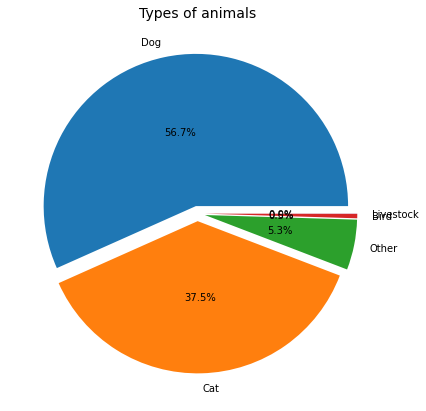

In [15]:
# Plot animal types in a chart
pie, ax = plt.subplots(figsize=[10, 7])
labels = animal_types.keys()
plt.pie(x=animal_types, autopct="%.1f%%", explode=[0.05]*len(labels), labels=labels, pctdistance=0.5)
plt.title("Types of animals", fontsize=14);

In [16]:
# Remove animals of type 'Livestock' and 'Other' because its of no use for the recomendation system
in_out_df = in_out_df.loc[in_out_df['animal_type'] != 'Livestock']

In [17]:
# See the different outcome types
outcome_labels = in_out_df['outcome_type'].unique()
total_records = in_out_df.shape[0]
outcome_types = in_out_df['outcome_type'].value_counts()
print("Outcome labels: ", outcome_labels)
print("Records total: ", total_records)
print("Values: \n", outcome_types)

Outcome labels:  ['Return to Owner' 'Transfer' 'Relocate' 'Adoption' 'Euthanasia' 'Died'
 'Rto-Adopt' 'Missing' 'Disposal' nan]
Records total:  121814
Values: 
 Adoption           53737
Transfer           36103
Return to Owner    21237
Euthanasia          8270
Died                1143
Rto-Adopt            675
Disposal             558
Missing               66
Relocate              20
Name: outcome_type, dtype: int64


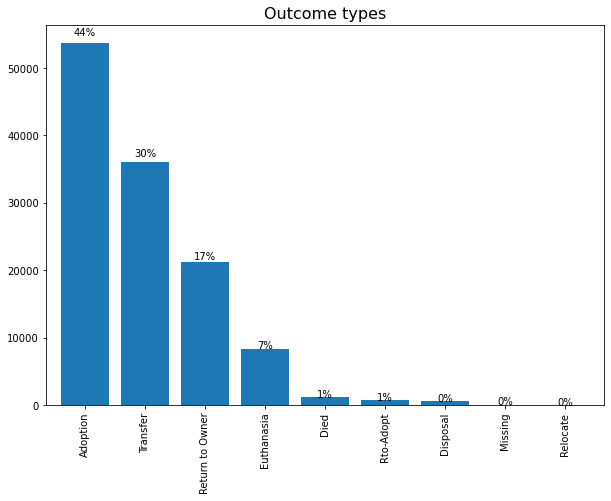

In [18]:
ax = outcome_types.plot(kind='bar', figsize=(10, 7), width=0.8, edgecolor=None)
plt.title("Outcome types",fontsize= 16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{(height / total_records):.0%}', (x + width/2, y + height*1.02), ha='center')


In [19]:
# Check income type
intake_types = in_out_df['intake_type'].value_counts()
intake_types

Stray                 85025
Owner Surrender       24007
Public Assist          7465
Wildlife               4836
Euthanasia Request      257
Abandoned               224
Name: intake_type, dtype: int64

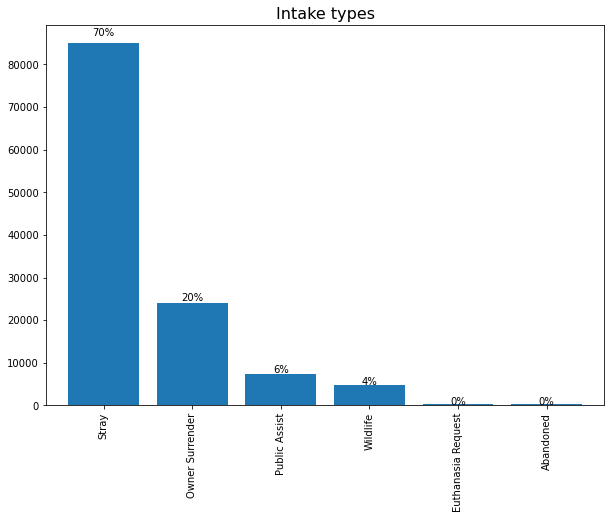

In [20]:
ax = intake_types.plot(kind='bar', figsize=(10, 7), width=0.8, edgecolor=None)
plt.title("Intake types",fontsize= 16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{(height / total_records):.0%}', (x + width/2, y + height*1.02), ha='center')

In [21]:
# Remove 'outcome_type' of 'Return to Owner'. For the recomendation system we don't want cases of 
# lost animals to train the model
in_out_df = in_out_df.loc[in_out_df['outcome_type'] != 'Return to Owner']

## Create column time in shelter using outcome and income times

In [22]:
in_out_df['time_in_shelter'] = in_out_df['outcome_time'] - in_out_df['income_time']
in_out_df['time_in_shelter'].describe()

count                     100577
mean     20 days 13:39:26.336239
std      51 days 23:01:49.305753
min         -2411 days +06:11:00
25%              2 days 20:58:00
50%              6 days 01:16:00
75%             20 days 23:27:00
max           1521 days 23:31:00
Name: time_in_shelter, dtype: object

In [23]:
# Remove rows where income_time is greater than outcome_time
in_out_df = in_out_df.loc[in_out_df['income_time'] < in_out_df['outcome_time']]

# Export dataframe

In [24]:
# in_out_df.to_csv('./data/in_out_shelter.csv', encoding='utf-8')

# Training + Testing

In [25]:
# Import libraries
from sklearn.model_selection import train_test_split

### Encode data

In [26]:
# Choose subtypes. Take into account every possible choice, no matter if the rows have been deleted
def subtype(x):
    if x['outcome_type'] == 'Adoption' and pd.isnull(x['outcome_subtype']) : return 'Adoption'
    elif x['outcome_type'] == 'Return_to_owner' and pd.isnull(x['outcome_subtype']): return 'Return to Owner'
    elif pd.isnull(x['outcome_type']) : return 'Other'
    else: return x['outcome_type']

in_out_df['outcome_subtype'] = in_out_df.apply(subtype, axis=1)

In [27]:
# Remove the secondary breed name.
def split_breed(x):
    if '/' in x['breed'] : return x['breed'].split('/', 1)[1]
    else : return x['breed']
    
in_out_df['breed'] = in_out_df.apply(split_breed, axis=1)
in_out_df['breed'] = in_out_df['breed'].str.replace(' Mix', '')

In [28]:
# Remove the secondary color name to focus on the principal color.
def split_color(x):
    if '/' in x['color'] : return x['color'].split('/', 1)[1]
    else : return x['color']
    
in_out_df['color'] = in_out_df.apply(split_color, axis=1)

In [29]:
# Divide sex_upon_outcome into 2: state + sex
in_out_df['state'], in_out_df['gender'] = in_out_df['sex_upon_outcome'].str.split(' ', 1).str

# Replace state values
in_out_df['state'] = in_out_df['state'].map({'Neutered': 'Fixed', 'Spayed': 'Fixed', 'Intact': 'Intact'})

In [30]:
# Create dummy values for those columns
state_dummies = pd.get_dummies(in_out_df['state'])
gender_dummies = pd.get_dummies(in_out_df['gender'])
animalType_dummies = pd.get_dummies(in_out_df['animal_type'])
breed_dummies = pd.get_dummies(in_out_df['breed'])
color_dummies = pd.get_dummies(in_out_df['color'])

# Only keep one, as we only have two variables.
state_dummies = state_dummies['Fixed']
gender_dummies = gender_dummies['Male']

# Combine the state binarization and the original dataset.
in_out_df = pd.concat([in_out_df, state_dummies, gender_dummies], axis=1)

# Change the name of the columns that we just concatenated.
in_out_df = in_out_df.rename(index=str, columns={'Fixed': 'isFixed(Fixed=1)', 'Male': 'isMale(Male=1)'})


# Need to keep all of the columns, as we have more than two breeds.
# Combine the breed binarization and the original dataset.
in_out_df = pd.concat([in_out_df, animalType_dummies, breed_dummies, color_dummies], axis=1)


In [31]:
print("Time: \n", in_out_df['age_upon_outcome'].unique())

# Map all age_upon_outcome values to numbers as we did in the test dataset. Mapped to weeks and rounded to the nearest week.
in_out_df['age_upon_outcome'] = in_out_df['age_upon_outcome'].map({'1 week': 1, '1 weeks': 1, '2 weeks': 2, 
                                                                   '3 weeks': 3, '4 weeks': 4, '5 weeks': 5, 
                                                                   '1 month': 4, '2 months': 9, '3 months': 13, 
                                                                   '4 months': 17, '5 months': 21, '6 months': 26, 
                                                                   '7 months': 30, '8 months': 34, '9 months': 38, 
                                                                   '10 months': 43, '11 months': 47, '1 year': 52, 
                                                                   '2 years': 204, '3 years': 156, '4 years': 208, 
                                                                   '5 years': 260, '6 years': 312, '7 years': 364, 
                                                                   '8 years': 416, '9 years': 468, '10 years': 520, 
                                                                   '11 years': 572, '12 years': 624, '13 years': 676, 
                                                                   '14 years': 728, '15 years': 780, '16 years': 832, 
                                                                   '17 years': 884, '18 years': 936, '20 years': 1040, 
                                                                   '0 years': 26, '1 day': 0, '2 days': 0, '3 days': 0, 
                                                                   '4 days': 0, '5 days': 0, '6 days': 0})

# Normalize age upon outcome.
in_out_df['age_upon_outcome_norm'] = in_out_df['age_upon_outcome']/max(in_out_df['age_upon_outcome'])

# Fill NaN values with the median value for the column.
in_out_df['age_upon_outcome_norm'].fillna(in_out_df['age_upon_outcome'].median(), inplace=True)


Time: 
 ['10 years' '18 years' '14 years' '16 years' '17 years' '19 years'
 '15 years' '13 years' '20 years' '12 years' '11 years' '9 years'
 '5 years' '8 years' '7 years' '6 years' '23 years' '4 years' '3 years'
 '2 years' '1 year' '10 months' '9 months' '11 months' '7 months'
 '8 months' '6 months' '3 months' '5 months' '4 months' '2 months'
 '1 week' '3 weeks' '1 weeks' '1 day' '1 month' '2 weeks' '3 days'
 '2 days' '4 weeks' '0 years' '4 days' '5 weeks' '5 days' '6 days'
 '-1 years' '25 years' '22 years' '-2 years' '21 years']


In [32]:
in_out_df.to_csv('./data/data_to_train.csv')

### Divide and prepare

In [184]:
# Split data
train_df, test_df = train_test_split(in_out_df, test_size=0.2, shuffle=True)

In [185]:
# Drop columns in test_df
test_df.drop(['outcome_type', 'outcome_subtype'], axis=1, inplace=True)